In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [2]:
df_weekly_sum = pd.read_csv('dpgr_gisaid_continents.csv')
print(df_weekly_sum)

     Clade                   Date       Location  Freq
0       GH  2019-12-30/2020-01-05         Africa    24
1       GH  2019-12-30/2020-01-05           Asia    98
2       GH  2019-12-30/2020-01-05         Europe   580
3       GH  2019-12-30/2020-01-05  North America   460
4       GH  2019-12-30/2020-01-05        Oceania    56
...    ...                    ...            ...   ...
2489   GRY  2022-03-14/2022-03-20  North America     1
2490   GRY  2022-03-21/2022-03-27         Europe     1
2491   GRY  2022-03-28/2022-04-03         Europe     1
2492   GRY  2022-04-25/2022-05-01  North America     1
2493   GRY  2022-05-02/2022-05-08         Europe     1

[2494 rows x 4 columns]


In [3]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['G','GH','GK','GR','GRA','GRY','GV','L','O','S','V']
VOC = ['GH','GK','GR','GRA','GRY']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Clade'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Clade'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Clade'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]
    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

# Scatterplots
*the `scatterplot(country, dataset, start, end, variants)` function generates the negative `regression plots` for GISAID labels at a target location within a time window, which has a start date and end date in the format ex: 2021-12 *

In [12]:
# This function finds the distance matrix among all the clades 

def scatterplot(country, dataset, start, end, variants):
    
    df_weekly = dataset[dataset['Location'] == country]
    

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Clade', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
    tmp.columns = ['0','1','2','3']

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
#     df_sum.to_csv(r'df_sum.csv')
#     print(df_sum)
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(df_)
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
#     print(df_)
 

    #scatterplot of omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc = {'figure.figsize':(3,3)})
    plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)
#     pango_compare = [variant] #'Omicron', 'Delta', 'Gamma', 'Beta', 'Alpha'
    marker = ['.', '+', 'v', 'x','*']
    legend=[]
    c=0
    # Create a list to store the slope values and corresponding locations
    slope_values = []

    for i in variants:
        if i != 'GK': #and i!='Alpha' and i != 'Gamma':# and i!='Delta' and i!='Beta':
            
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['GK vs {0}'.format(i)])
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask],df_['GK vs {0}'.format(i)][mask])
#             print('test')
#             print(slope)
#             print(intercept)
            slope_values.append((country, slope))  # Append tuple of location and slope value
            print(slope_values)
            sns.regplot(x=df_['days'], y=df_['GK vs {0}'.format(i)], marker=marker[c],scatter_kws={'s':50},label='GK vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
            # legend.append('BA.5 vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
        c+=1
        
    
    #Save the slope values of corresponding countries to a CSV file
    # Define the file path to save the CSV
    csv_file = 'gra_Vs_gk_negative_slope_values_continents.csv'

    # Append the slope values to the CSV file
    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:
            writer.writerow(['Location', 'Slope'])  # Write the header row if the file is empty
        writer.writerows(slope_values)  # Append the slope values
    
    print('Slope values saved to', csv_file)
    
    
#     plt.legend(loc='upper left', prop={'size': 10}, facecolor='white')
    plt.legend(loc='upper left', prop={'size': 5.7}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize= 7.5, labelpad=1)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant}_1}{\mathrm{Variant}_2}\right)$', fontsize=8)
    plt.title(f'GK Vs. GRA \n Time Window: ({start}) - ({end}) \n Location : {country}', fontsize=7.5)
    plt.xlabel('Days', fontsize = 7.5)  # Set x-axis label and adjust font size
    plt.rc('axes', labelsize=7.5)  # Adjust the label font size
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')  # Set plot background color to white
    # plt.savefig(country+"_slope"+'.png')

    # Add vertical bars for x-axis and y-axis without changing the range
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))  # Vertical bar for y-axis
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))  # Vertical bar for x-axis
    
    import os
    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/gra_vs_gk_negative_regression_plots/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, country + "_regression_gra_vs_gk_negative.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.savefig(country+"_slope"+'.png')
    

# Regression plots `(Continent level)` for `GK Vs. GRA`  `->`  `Delta Vs Omicron` 

['2022-03', '2022-04', '2022-05']
[('North America', -0.008249209140422658)]
Slope values saved to gra_Vs_gk_negative_slope_values_continents.csv


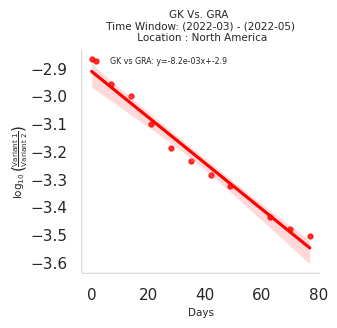

In [13]:
scatterplot('North America', df_weekly_sum, start = '2022-03', end = '2022-05', variants = ['GRA'])

['2021-12']
[('South America', -0.05540998420742065)]
Slope values saved to gra_Vs_gk_negative_slope_values_continents.csv


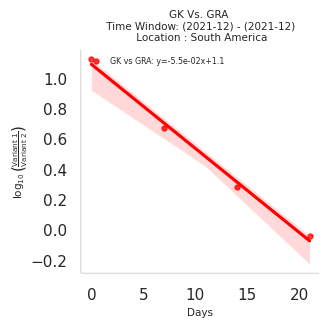

In [14]:
scatterplot('South America', df_weekly_sum, start = '2021-12', end = '2021-12', variants = ['GRA'])

['2022-02', '2022-03']
[('Europe', -0.009914884959436283)]
Slope values saved to gra_Vs_gk_negative_slope_values_continents.csv


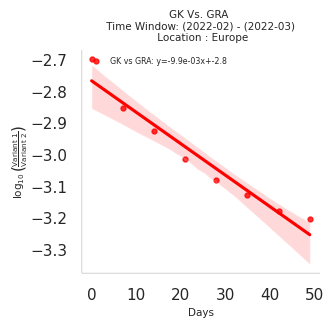

In [15]:
scatterplot('Europe', df_weekly_sum, start = '2022-02', end = '2022-03', variants = ['GRA'])

['2022-01', '2022-02', '2022-03', '2022-04']
[('Oceania', -0.006391809718537095)]
Slope values saved to gra_Vs_gk_negative_slope_values_continents.csv


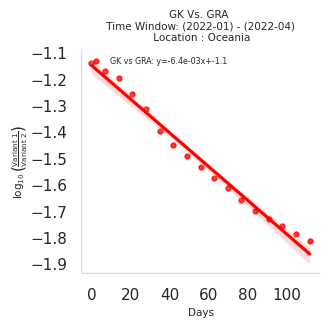

In [16]:
scatterplot('Oceania', df_weekly_sum, start = '2022-01', end = '2022-04', variants = ['GRA'])

['2021-12']
[('Asia', -0.05767270706144409)]
Slope values saved to gra_Vs_gk_negative_slope_values_continents.csv


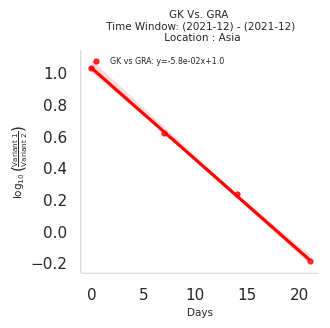

In [17]:
scatterplot('Asia', df_weekly_sum, start = '2021-12', end = '2021-12', variants = ['GRA'])

['2021-11', '2021-12']
[('Africa', -0.035182515133624255)]
Slope values saved to gra_Vs_gk_negative_slope_values_continents.csv


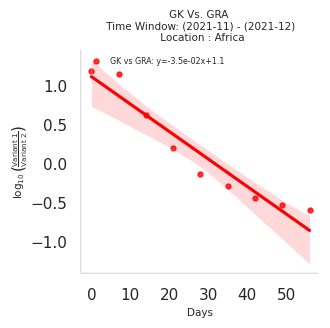

In [18]:
scatterplot('Africa', df_weekly_sum, start = '2021-11', end = '2021-12', variants = ['GRA'])

# `Bar Plot` of the slope values in diffeerent `Continents`

In [19]:
slope_values_of_continents = pd.read_csv('gra_Vs_gk_negative_slope_values_continents.csv')
print(slope_values_of_continents)

        Location     Slope
0  North America -0.008249
1  South America -0.055410
2         Europe -0.009915
3        Oceania -0.006392
4           Asia -0.057673
5         Africa -0.035183


In [20]:
slope_values_of_continents = slope_values_of_continents.drop_duplicates()
print(slope_values_of_continents.describe())
print("\n")

# Find the minimum and maximum slope values
min_slope_value = slope_values_of_continents['Slope'].min()
max_slope_value = slope_values_of_continents['Slope'].max()

# Find the corresponding countries for the minimum and maximum slope values
min_slope_continents = slope_values_of_continents[slope_values_of_continents['Slope'] == min_slope_value]['Location']
max_slope_continents = slope_values_of_continents[slope_values_of_continents['Slope'] == max_slope_value]['Location']

# Print the results
print(f"Min Slope Value: {min_slope_value}")
print(f"Country: {', '.join(min_slope_continents)}")
print("\n")
print(f"Max Slope Value: {max_slope_value}")
print(f"Country: {', '.join(max_slope_continents)}")
print("\n")
print(f"Average Slope Value: {slope_values_of_continents['Slope'].mean()}")


          Slope
count  6.000000
mean  -0.028804
std    0.023931
min   -0.057673
25%   -0.050353
50%   -0.022549
75%   -0.008666
max   -0.006392


Min Slope Value: -0.057672707061444
Country: Asia


Max Slope Value: -0.006391809718537
Country: Oceania


Average Slope Value: -0.02880351837014743


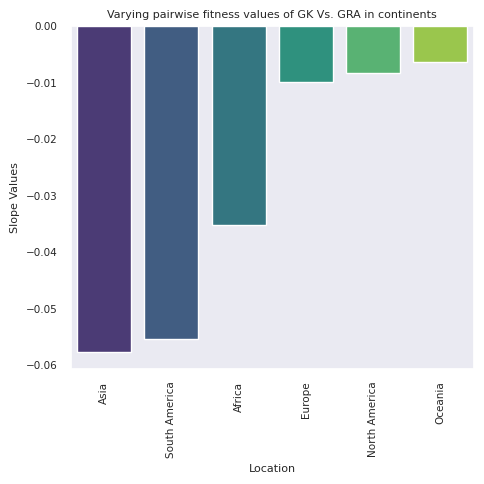

In [22]:
# Sort the DataFrame by 'Slope' column in ascending order
slope_values_of_continents = slope_values_of_continents.sort_values('Slope', ascending=True)

# Define the color palette
color_palette = sns.color_palette('viridis', len(slope_values_of_continents))

# Plot the bar plot with the specified color palette
plt.figure(figsize=(5, 5))
sns.barplot(x='Location', y='Slope', data=slope_values_of_continents, palette=color_palette)
plt.xlabel('Location', fontsize = 8)
plt.ylabel('Slope Values', fontsize =8)
plt.title('Varying pairwise fitness values of GK Vs. GRA in continents', fontsize = 8)
plt.xticks(rotation=90)
plt.grid(False)  # Turn off the grid lines
plt.tight_layout()

# Specify the directory path
directory = "/scr/mjpantho/Pantho_differential_fitness/gra_vs_gk_negative_regression_plots/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the figure to the specified directory with DPI set to 300
filename = os.path.join(directory, "continents_bar_plot_gra_vs_gk_negative.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

# Display the figure
plt.show()
